# Agent Codes, Runs and Fixes Bugs Automatically Based on User Prompt

**Objective**: Develop a Multi-Agent AI system that generates code based on user prompts, runs experiments, and fixes bugs in Python code as needed.

**Technologies Used**: Langchain, Langgraph, Gemini API, DuckDuckGo Search

In [1]:
!pip install --upgrade --quiet langchain==0.2.16 langchain-community==0.2.16 langchain-openai==0.1.23 langgraph==0.2.18 langsmith==0.1.114 pdfplumber python-dotenv langchain-google-genai duckduckgo-search -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.8/96.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.0/290.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.2/164.2 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.3/718.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 

In [2]:
import subprocess # run cmd
import shlex
# agent create
from langgraph.graph import StateGraph, END, START
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import SystemMessage, HumanMessage
from dotenv import load_dotenv
from typing import Dict, TypedDict
from langchain.tools import BaseTool, StructuredTool, tool
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.tools import DuckDuckGoSearchResults #searching tools
import os
import re
from tenacity import retry, stop_after_attempt, wait_fixed

**State** plays a crucial role in determining the objects stored in the shared memory between agents.

Define State:

- **Prompt**: Stores the user's request or input.
- **File_path**: Stores the generated code file.
- **Output**: Stores the result of the execution process.

In [30]:
load_dotenv()
# Khởi tạo Gemini API (thay YOUR_GEMINI_API_KEY bằng key của bạn)
llm = ChatGoogleGenerativeAI(model="learnlm-1.5-pro-experimental",
                             verbose=True,
                             temperature=0.5,
                             google_api_key=os.getenv("GOOGLE_API_KEY"))

In [6]:
class State(TypedDict):
    prompt: str
    file_path: str
    output: str

In [7]:
# Importing message types and utilities from langchain_core:
# AIMessage, HumanMessage, SystemMessage: Define different types of messages in a conversation.
# trim_messages: Utility to manage and limit the number of messages in a conversation history.
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, trim_messages

def trim_conversation(prompt):
    """Trims conversation history to retain only the latest messages within the limit."""
    max_messages = 10  # Limit the conversation history to the latest 10 messages
    return trim_messages(
        prompt,
        max_tokens=max_messages,  # Specifies the maximum number of messages allowed
        strategy="last",  # Trimming strategy to keep the last messages
        token_counter=len,  # Counts tokens/messages using the length of the list
        start_on="human",  # Start trimming when reaching the first human message
        include_system=True,  # Include system messages in the trimmed history
        allow_partial=False,  # Ensures only whole messages are included
    )


### Define custom Tools

In [8]:
@tool
def run_command(command: str) -> str:
    """Executes a shell command and returns its output."""
    result = subprocess.run(shlex.split(command), shell=True, capture_output=True, text=True)
    return (result.stdout or "") + (result.stderr or "")

@tool
def save_file_python(code: str, file_path: str) -> bool:
    """Save the python code on local and return save state."""
    try:
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(code)
        print(f"Code saved successfully to '{file_path}'")
        return True
    except Exception as e:
        print(f"An error occurred while saving the code: {e}")
        return False

@tool
def read_file_python(file_path: str) -> str:
    """Read code in a python file and return code in file on local."""
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            file_content = file.read()
        return file_content
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return ""

### Route Agent

The **`route_results`** function is responsible for directing the code either to the bug-fix agent or marking it as completed.


In [9]:
def route_result(state: State):
    try:
        if "error" in state["output"].lower():
            return "fix_bug"
        else:
            return "end"
    except:
        return "end"

### Define Agents


Define Agent:

- **Code Generation Agent**: Generates code based on user prompts.
- **Execution Agent**: Executes the code and installs necessary libraries.
- **Bug-Fixing Agent**: Identifies and fixes bugs in the code.

In [10]:
def generate_python_code(query):
    """Generate Python code from prompt using Gemini API"""
    system_prompt = "You are an AI assistant that generates accurate and optimized Python code. Do not respond to unrelated requests. After generating accurate and clean code, save it locally. Finally, return the file path as output."
    prompt = ChatPromptTemplate.from_messages([("system", system_prompt),
            ("placeholder", "{chat_history}"),
            ("human", "{input}"),
            ("placeholder", "{agent_scratchpad}"),])

    agent = create_tool_calling_agent(llm, [save_file_python], prompt)
    agent_executor = AgentExecutor(agent=agent, tools=[save_file_python], verbose=True)
    response = agent_executor.invoke({"input": query})
    return response.get('output')

In [12]:
def run_python_code(file):
    """Run Python code using subprocess"""
    system_prompt = """You are an expert at running Python code on the Windows command line with accuracy and responsibility. Given a Python file, read the code in the file, install the necessary libraries via pip, and then run the code. Only return the command line output as the result.
Example: UnicodeDecodeError: 'charmap' codec can't decode byte 0x9d in position 42: character maps to <undefined>
    """

    query = f"Successfully run this Python file locally. Here is the local file path: {file}."


    prompt = ChatPromptTemplate.from_messages([("system", system_prompt),
            ("placeholder", "{chat_history}"),
            ("human", "{input}"),
            ("placeholder", "{agent_scratchpad}"),])

    agent = create_tool_calling_agent(llm, [run_command, read_file_python], prompt)
    agent_executor = AgentExecutor(agent=agent, tools=[run_command, read_file_python], verbose=True)
    response = agent_executor.invoke({"input": query})
    return response.get('output')

In [28]:
def fixbug(query, file, error):
    """Fix bugs in Python code"""
    system_prompt = f"""You are a highly experienced, meticulous, and accurate bug-fixing expert.
You are familiar with the following environment: notebook colab with CPU.
You will receive the code file with the path {file}, read the code, and the current errors in the code.
The original user request is {query}.
Analyze and find the best way to fix the error. Edit the file, save it, and run the command to install any necessary libraries (if required) and execute the saved code to test it.
If no errors are fixed, return 'Complete' as the only output. If new errors occur, return the error message displayed from the command line as the output."""
    tools = [
        DuckDuckGoSearchResults(name="search_tool"),
        run_command,
        save_file_python,
        read_file_python
    ]
    try_count = 0
    while True:
        e = f"Fix the current error: {error}"
        prompt = ChatPromptTemplate.from_messages([("system", system_prompt),
                ("placeholder", "{chat_history}"),
                ("human", "{input}"),
                ("placeholder", "{agent_scratchpad}"),])

        agent = create_tool_calling_agent(llm, tools, prompt)
        agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
        response = agent_executor.invoke({"input": e})

        if 'complete' in response.get("output").lower():
            break
        error = response.get("output")
        try_count += 1
        if try_count > 10:
            break
    return response.get('output')

In [24]:
# Xây dựng LangGraph
class CodeAgent:
    def __init__(self):
        self.workflow = StateGraph(State)


        self.workflow.add_node("generate", self.generate_code)
        self.workflow.add_node("execute", self.execute_code)
        self.workflow.add_node("fix_bug", self.fix_bug_agent)

        self.workflow.add_edge(START, "generate")
        self.workflow.add_edge("generate", "execute")
        self.workflow.add_conditional_edges(
            "execute",
            route_result,
            {
                "fix_bug": "fix_bug",
                "end": END
            }
        )
        self.workflow.add_edge("fix_bug", END)

        self.workflow.set_entry_point("generate")
        self.app = self.workflow.compile()

    def generate_code(self, state: State) -> State:
        state["file_path"] = generate_python_code(state["prompt"])
        return state

    def execute_code(self, state: State) -> State:
        state["output"] = run_python_code(state["file_path"])
        return state

    def fix_bug_agent(self, state: State) -> State:
        state["output"] = fixbug(state["prompt"], state["file_path"], state["output"])
        return state

    @retry(stop=stop_after_attempt(3), wait=wait_fixed(2))  # Thử lại tối đa 3 lần, chờ 2s mỗi lần
    def run(self, prompt):
        return self.app.invoke({"prompt": prompt})

### Lets Visualize our graph
- Displaying Workflow Graph:

  - Generates a visual representation of the app workflow graph using Mermaid, which is then displayed as a PNG image.
  - The MermaidDrawMethod.API method is used to create the PNG, ensuring a clear, structured view of the workflow nodes and their connections.

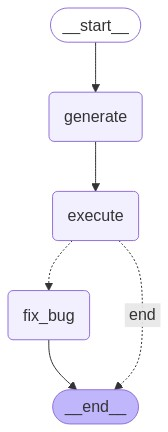

In [31]:
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod # to visualize the graph of langgraph node and edges

agent = CodeAgent()
# Display the workflow graph as a PNG image using Mermaid
display(
    Image(
        agent.app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,  # Uses Mermaid's API to generate the PNG image of the workflow graph
        )
    )
)

### Test

In [32]:
user_prompt = input("Enter your request for code Python: ")
result = agent.run(user_prompt)
print("\nGenerated Code:\n", result["file_path"])
print("\nExecution Output:\n", result["output"])

Enter your request for code Python: Code hình trái tim và hiển thị 




> Entering new AgentExecutor chain...

Invoking: `save_file_python` with `{'file_path': 'heart.py', 'code': "import turtle\n\npen = turtle.Turtle()\n\npen.fillcolor('red')\npen.begin_fill()\npen.left(140)\npen.forward(180)\npen.circle(-90, 200)\npen.setheading(60)\npen.circle(-90, 200)\npen.forward(180)\npen.end_fill()\n\npen.hideturtle()\n\nturtle.done()\n"}`


Code saved successfully to 'heart.py'
True

File path: heart.py.


> Finished chain.


> Entering new AgentExecutor chain...

Invoking: `read_file_python` with `{'file_path': 'heart.py'}`


import turtle

pen = turtle.Turtle()

pen.fillcolor('red')
pen.begin_fill()
pen.left(140)
pen.forward(180)
pen.circle(-90, 200)
pen.setheading(60)
pen.circle(-90, 200)
pen.forward(180)
pen.end_fill()

pen.hideturtle()

turtle.done()

Invoking: `run_command` with `{'command': 'pip install PythonTurtle'}`



Usage:   
  pip3 <command> [options]

Commands:
  install                     Install packages.
  download                    Download packages.
  uninstall                   Uninstall packages.
  freeze                      Output installed packages in requirements format.
  inspect                     Inspect the python environment.
  list                        List installed packages.
  show                        Show information about installed packages.
  check                       Verify installed packages have compatible dependenc